In [1]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
import io
from random import shuffle
import shutil
import cv2
%matplotlib inline

### parse xml to df

In [2]:
annot_path='/home/silas/MIDS/W251/final_project/annotations'
os.chdir(annot_path)

In [3]:
# parse xml to dataframe
def parse_xml(xml_file_name):
    tree = ET.parse(xml_file_name)  
    root = tree.getroot()
    lst=[]
    for elems in root:
        # print(elems.attrib)
            for subelem in elems:
                if subelem.attrib.get('label') != None:
                    subelem.attrib.update(id=elems.attrib.get('id'))
                    subelem.attrib.update(names=elems.attrib.get('name'))
                    subelem.attrib.update(width=elems.attrib.get('width'))
                    subelem.attrib.update(height=elems.attrib.get('height'))
                    lst.append(subelem.attrib)
    columns=subelem.attrib.keys()
    df=pd.DataFrame(lst,columns=columns)
    # df['names']=df.names.apply(lambda x: x.split('/')[1])
    return df


In [4]:
df_silas=parse_xml('construction_annotations_silas.xml')
df_sudha=parse_xml('constructions_annotations_sudha.xml')
df_andrew=parse_xml('construction_annotations_andrew.xml')
df=pd.concat([df_andrew,df_sudha,df_silas])

In [7]:
# standarize id
df=df.drop('id',axis=1)
# normalize file names remove '/'
df['names']=[name.split('/')[1] if '/' in name else name.split('/')[0] for name in df.names.values]
# add splits for train and val to df
uniq_names=sorted(list(set(df.names)))
size=len(uniq_names)
t_size=.8
v_size=1-t_size
index_split=['train']*int(np.round(size*t_size,0))+['val']*int(np.round(size*v_size,0))
shuffle(index_split)
df1=pd.DataFrame()
df1['id']=[i for i in range(df.names.unique().shape[0])]
df1['split']=index_split
df1['names']=uniq_names
df_split=df.merge(df1, on='names')
df_split=df_split[['label', 'xtl', 'ytl', 'xbr', 'ybr', 'occluded', 'id', 'names', 'width',
       'height', 'split']]


### quick look at df

In [8]:
df_split[['label','names','split']].describe().T

,count,unique,top,freq
label,8882,3,person,4421
names,8882,1009,Sequence07_339.jpeg,43
split,8882,2,train,6957


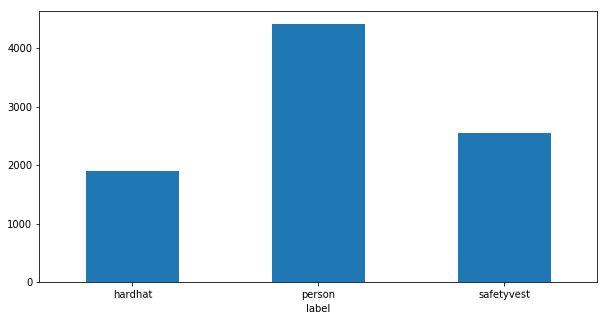

In [251]:
pd.DataFrame([df_split.label.astype('category').cat.codes,df_split.label]).T.groupby(['label']).count().plot(figsize=(10,5),kind='bar',rot=.40, legend=False)
# plot(kind='hist',index=['a','b'],xticks=None)

### other formats

In [245]:
# templates
kitti_template = "{label} 0.00 0 0.0 {xtl} {ytl} {xbr} {ybr} 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0"
voc_pascal_template_outer= '  <image id="{}" name="{}" width="{}" height="{}">' 
voc_pascal_template_head='  <version>1.1</version>\n  <meta>\n    <task>\n      <id>1</id>\n      <name>ahl251</name>\n      <size>{}</size>\n      <mode>annotation</mode>\n      <overlap>0</overlap>\n      <bugtracker/>\n      <flipped>False</flipped>\n      <created>2019-03-30 23:40:47.695960+03:00</created>\n      <updated>2019-03-31 06:51:49.089135+03:00</updated>\n      <labels>\n        <label>\n          <name>person</name>\n          <attributes> </attributes>\n        </label>\n          <label>\n            <name>safetyvest</name>\n            <attributes> </attributes>\n        </label>\n          <label>\n            <name>hardhat</name>\n            <attributes> </attributes>\n        </label>\n          </labels>\n      <segments>\n        <segment>\n         <id>117</id>\n         <start>0</start>\n         <stop>{}</stop>\n         <url>http://c.onepanel.io/?id=117</url>\n        </segment>\n      </segments>\n      <owner>\n        <username>admin</username>\n        <email>admin@onepanel.io</email>\n      </owner>\n    </task>\n    <dumped>2019-03-31 06:51:51.787681+03:00</dumped>\n  </meta>'
voc_pascal_template_inner= '    <box label="{}" xtl="{}" ytl="{}" xbr="{}" ybr="{}" occluded="{}"> </box>'
template_test= '  <box label="{label}" xtl="{xtl}" ytl="{ytl}" xbr="{xbr}" ybr="{ybr}" occluded="{occluded}"> </box>'

# for yolo see below

### voc_pascal

In [121]:
df=df_split
src_dir='all_images/'
dst_dir_img = 'voc/images/'
dst_dir_labels = 'voc/labels/'
os.makedirs(dst_dir_img)
os.makedirs(dst_dir_labels)

xml_output=[]
img_names=sorted(list(set(df.names)))
for nm in img_names:
    
    shutil.copy(src_dir+nm, dst_dir_img)  # save valid images to voc dir
    
    header=list(df[df.names==nm].iloc[:,6:].values[0])
    xml_output.append(voc_pascal_template_outer.format(*header))
    rows=df[df.names==nm].iloc[:,:6].reset_index(drop=True)
    for idx in range(rows.T.shape[1]):
        row=list(rows.T[idx].values)
        xml_output.append(voc_pascal_template_inner.format(*row))
        if idx == rows.T.shape[1]-1:
            xml_output.append('  </image>')

with open(dst_dir_labels+"construction_annotations_v1" + ".xml", "w") as text_file:
    text_file.write("<annotations>\n")
    text_file.write(voc_pascal_template_head.format(*[df.names.unique().shape[0]]*2))
    text_file.write("\n".join(xml_output))
    text_file.write("\n</annotations>")

shutil.make_archive('voc/'+'images', 'zip', dst_dir_img)

'/home/silas/MIDS/W251/final_project/annotations/voc/images.zip'

### kitti

In [ ]:
# create file structure

os.chdir('/home/silas/MIDS/W251/final_project/annotations/')
os.makedirs('data/train/images')
os.makedirs('data/train/labels')
os.makedirs('data/val/images')
os.makedirs('data/val/labels')

def apply_split_kitti(df,split_type):
    """
    Arg: split_type takes either 'train' or 'val'
    Creates separate .txt files for each img annotation using kitti format
    """
    split_type=split_type
    # get all val
    test_df=df_split[df_split.split==split_type]
    # get all unique names of images in val
    unique_lst=test_df.names.unique()
    # get a dataframe representing a unique name of image
    #tmp=df_test[df_test.names==img].reset_index(drop=True)
    for img in unique_lst:
    
        filename=img.split('.')[0]
    
        tmp=test_df[test_df.names==img].reset_index(drop=True)
    
        for i in range(tmp.shape[0]):
        
            inner=kitti_template.format(**tmp.loc[i].to_dict())
            completeName = os.path.join('data/{}/labels'.format(split_type), filename+".txt")
        
            with open(completeName, "a") as text_file:
                text_file.write(inner+'\n')
        
            src_dir='all_images/'
            dst_dir = "data/{}/images".format(split_type)
            shutil.copy(src_dir+img, dst_dir)
            
apply_split_kitti(df_split,'val')
apply_split_kitti(df_split,'train')

In [ ]:
"""
# directory and file structure kitti

all_images

data
    train
        image
            <name_of_image>.img
        label
            <name_of_label>.txt
    val
        image
            <name_of_image>.img
        label
            <name_of_label>.txt
""";

### yolo

In [214]:
def yolo_df(df):
    df_yolo=pd.DataFrame()
    df_yolo=df.iloc[:,1:5].astype('float')
    df_yolo['label']=df.label.astype('category').cat.codes
    df_yolo['name']=df.names
    df_yolo['label_']=df.label
    return df_yolo

In [235]:
def yolo_format(df_yolo):
    X1 = df_yolo['xtl']
    X2 = df_yolo['xbr']
    Y1 = df_yolo['ytl']
    Y2 = df_yolo['ybr']
    name=df_yolo.name
    return df_yolo.label, (X1+(X2-X1)/2)/640, (Y1+(Y2-Y1)/2)/360, (X2-X1)/640, (Y2-Y1)/360, name

In [ ]:
path=os.getcwd()
os.makedirs(path+'/yolo/data/obj')
df_y=yolo_df(df_split)
obj_path=os.path.join(path, 'yolo','data', 'obj')

# make all img .txt files and store in obj directory
for un in df_y.name.unique():
    df_tmp=df_y[df_y.name==un].reset_index(drop=True)
    label,x,y,width,height,name=yolo_format(df_tmp)

    for item in list(zip(label,x,y,width,height)):
        row='{} {:2f} {:2f} {:2f} {:2f}'.format(item[0], item[1], item[2], item[3], item[4])
        path_txt= os.path.join(obj_path, un.replace('.jpeg','.txt'))
        
        with open(path_txt, "a") as text_file:
            text_file.write(row+'\n')
            
        src_dir='all_images/'
        shutil.copy(src_dir+un, obj_path) 
        
# make train.txt
for img in sorted([i for i in os.listdir(obj_path) if '.jpeg' in i]):
    with open(os.path.join('yolo','data', 'train.txt'), "a") as train_txt:
        train_txt.write(os.path.join('yolo','data', img)+'\n')

# write obj.data file 
objs='classes={}\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = backup/'.format(df_y.label.nunique())

with open (os.path.join('yolo','data', 'obj.data'), "a") as obj_data:
    obj_data.write(objs) 

# make obj.names file 
for labl in sorted(df_y.label_.unique()):
    with open(os.path.join('yolo','data', 'obj.names'), "a") as text_file:
            text_file.write(labl+'\n')
    with open(os.path.join(obj_path, 'classes.txt'), "a") as text_file:
            text_file.write(labl+'\n')

In [ ]:
"""
# yolo directory and file structure

data
    obj.names
        person
        hardhat
        safetyvest
    
    
    obj.data
       '''
       # write in file
        classes= 2
        train  = data/train.txt
        valid  = data/test.txt
        names = data/obj.names
        backup = backup/
       '''
        
    train.txt
        data/obj/1.jpg
        data/obj/2.jpg
       
        
    obj/
      1.jpg
      1.txt  
      2.jpg
      2.txt
"""   
    

### scraps to see bounding boxes on images

In [ ]:
df_see=df_split.iloc[:,1:5].astype(float)
xmin,ymin,xmax,ymax=df_see.loc[0].to_dict().values()

In [ ]:
# take an example
df_see['names']=df_split['names']
bb1=df_see.loc[0][4]
img=cv2.imread('all_images/{}'.format(bb1))

In [ ]:
rect=cv2.rectangle(img,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(100,0,0),1)

In [ ]:
cv2.imshow('dst_rt', rect)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# self draw bbox with cv2
r = cv2.selectROI(img)